# MNIST Example
In this notebook we'll use the `vegans` library to generate some fake handwritten digits, using a generator and discriminator of our choice. 

### Initial Setup
First, some imports:

In [10]:
import os
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import vegans.utils.loading as loading
from vegans.GAN import WassersteinGAN, WassersteinGANGP
from vegans.utils.utils import plot_losses, plot_images

In [2]:
# do we have cuda?
print('Cuda is available: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda is available: False


Now download the mnist dataset and set the parameters below (To get exactly the same format as in this tutorial download from [here](https://github.com/tneuer/GAN-pytorch/tree/main/data/mnist), but of course you can load it from anywhere you want):

In [3]:
# This directory will contain the MNIST data
datapath = "./data"

# Size of z latent vector (i.e. size of generator input)
z_dim = [1, 4, 4]

# Input channels 
nc = 1

# Padding for mnist images (28x28) -> (32x32)
pad = 2

Now load and preprocess the data:
- The images are saved in gray scale from 0-255, so we scale it to 0-1. Then we can use a Sigmoid as the last layer of the generator.
- The original image shape is (28, 28) but when working with convolutional layers it is often beneficial to have a power of two. Therefore we pad two empty rows and columns to every image.
- Finally we reshape the images because we need the images in the shape of (nr_channels, nr_heiht_pixels, nr_width_pixels). In out case this results in [1, 32, 32]

In [4]:
""" Create dataset
"""
X_train, y_train, X_test, y_test = loading.load_data(datapath, which="mnist", download=True)

X_train = X_train.reshape((-1, 1, 32, 32))
X_test = X_test.reshape((-1, 1, 32, 32))
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)
print(X_train.shape, X_test.shape)

x_dim = X_train.shape[1:]

(60000, 1, 32, 32) (10000, 1, 32, 32)


Plot some of the training images:

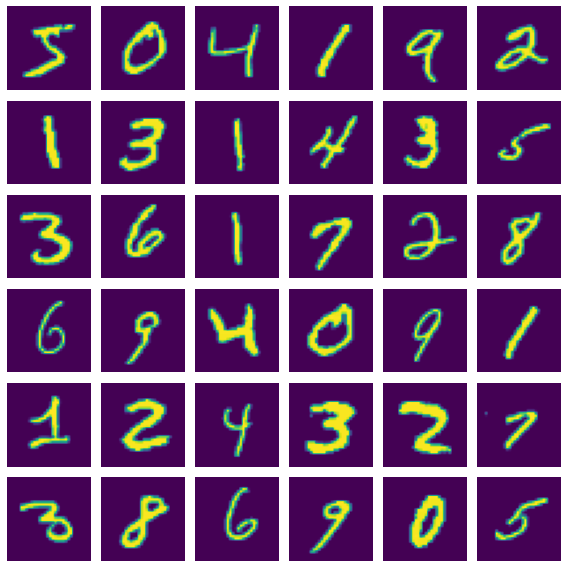

In [5]:
fig, axs = plot_images(images=X_train.reshape(-1, 32, 32))

### Definition of Generator and Discriminator / Critic
We'll specify the architecture of the generator and discriminator / critic networks. It's difficult to know which architectures to choose before training. Here we used a architecture which proved to work.

Since we want to train a Wasserstein GAN, the output of the critic should be a real number and not a probability. Therefore we drop the last sigmoid and use the identity function. If you want to switch to a architecture that uses a discriminator switch the `nn.Identity` with `nn.Sigmoid` for the adversary.

In [6]:
""" Generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        ngf = 20
        self.hidden_part = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim[0], out_channels=ngf * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.1),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.1),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ngf, ngf, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 5, 1, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nc, nc, kernel_size=3, stride=1, padding=1),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
""" Adversary
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        ncf = 8
        self.hidden_part = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(in_channels=nc, out_channels=ncf, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf) x 16 x 16
            nn.Conv2d(ncf, ncf * 2, 4, 2, 1),
            nn.BatchNorm2d(ncf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*2) x 8 x 8
            nn.Conv2d(ncf * 2, ncf * 4, 4, 2, 1),
            nn.BatchNorm2d(ncf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*4) x 4 x 4
            nn.Conv2d(ncf * 4, ncf * 8, 4, 2, 1),
            nn.BatchNorm2d(ncf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*8) x 2 x 2
            nn.Flatten(),
            nn.Linear(in_features=ncf*8*2*2, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1)
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
generator = Generator()
critic = Critic()

### Train our GAN
Build a Wasserstein GAN trainer, using default optimizers (we can also specify our own). To use a different GAN algorithm, just use the corresponding class (e.g., `VanillaGAN` for original GAN).

Here you can specify some optional GAN parameters, such as the latent space dimension `z_dim`, the number of samples to save (`fixed_noise_size`) and the optimizer keyword arguments (`optim_kwargs`). We set `folder=None` so that no folder is created where all results would be stored. Otherwise we could give a path like `folder="TrainedModels/GAN"`. All results (summary, images, loss functions, tensorboard information, models) would be saved in that folder. You can control what should be saved in the `fit` method. This folder will never overwrite an existing folder. If the path already exists a new path of the form `folder=path_{TimeStamp}` is created.

We also decrease the learning rate of the critic a little.

In [7]:
optim_kwargs = {"Generator": {"lr": 0.0005}, "Adversary": {"lr": 0.0001}}
gan = WassersteinGAN(
    generator, critic, z_dim=z_dim, x_dim=x_dim, 
    optim_kwargs=optim_kwargs, fixed_noise_size=20, folder=None
)

In [8]:
gan.summary()

Generator
---------
Input shape:  (1, 4, 4)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 160, 4, 4]           1,600
       BatchNorm2d-2            [-1, 160, 4, 4]             320
         LeakyReLU-3            [-1, 160, 4, 4]               0
   ConvTranspose2d-4             [-1, 80, 8, 8]         204,880
       BatchNorm2d-5             [-1, 80, 8, 8]             160
         LeakyReLU-6             [-1, 80, 8, 8]               0
   ConvTranspose2d-7           [-1, 40, 16, 16]          51,240
       BatchNorm2d-8           [-1, 40, 16, 16]              80
         LeakyReLU-9           [-1, 40, 16, 16]               0
           Conv2d-10           [-1, 40, 16, 16]          14,440
      BatchNorm2d-11           [-1, 40, 16, 16]              80
        LeakyReLU-12           [-1, 40, 16, 16]               0
  ConvTranspose2d-13           [-1, 20, 32, 32]          12

Train the networks by calling the `fit()` method. Here you can specify some parameters for training like `eochs`, `batch_size`, `save_model_every`, `save_images_every`, `print_every`, `enable_tensorboard` and others.

You can interrupt training at any time and still access train stats from within the `gan` object. You can resume training later. Note that we increase the number of steps the critic (adversary) is trained, which is common for Wasserstein GANs but not VanillaGANs so take care when switching out algorithms.

In [9]:
steps = {"Adversary": 5}
gan.fit(
    X_train, epochs=5, steps=steps,
    print_every="0.25e", save_losses_every=10, enable_tensorboard=False
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
samples, losses = gan.get_training_results()
fig, axs = plot_losses(losses)
print(samples.shape)

In [ ]:
fig, axs = plot_images(samples.reshape(-1, 32, 32), n=9)

Now we want to generate new images and have control over the number of generated images. Note that the `get_training_results` returns as many images as were specified with the `fixed_noise_size` argument in the constructor when creating the GAN.

In [ ]:
new_samples = gan.generate(n=100)
print(new_samples.shape)
fig, axs = plot_images(samples.reshape(-1, 32, 32))